# Perfect foresight experiments with dolo

**Fiscal policy experiments in a non-stochastic model**

**Spencer Lyon** _NYU Stern Economics_

**Pablo Winant** _Bank of England_

February 2019

In [1]:
# imports and workspace setup
%matplotlib inline
from dolo import yaml_import, pcat
import dolo.algos.perfect_foresight as pf
from dolo.algos.steady_state import find_steady_state
from dolo.misc.graphs import plot_irfs
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("ggplot")

In this notebook we will explore the effects of techonology and fiscal policy shocks in a nonstochastic model. The model and figures are inspired by chapter 11 of Recursive Macroeconomic Theory 3rd edition (RMT3) by Ljungqvist and Sargent. 

We will focus on the computational aspects of the exercises and will refer the interested reader to section 11.9 of RMT3 for a discussion on the underlying economics.

## Model

A representative household has preferences over consumption that are ordered by 

$$U := \sum_{t=0}^{\infty} \beta^t \frac{c_t^{1-\gamma}}{1-\gamma},$$

where $\beta = 0.95$ is the agent's discount factor and $\gamma$ is the coeffiicent of relative risk aversion.

A perfectly competitive representative firm rents capital $k_t$ from the household and produces using the production function $f(k) = A k^{\alpha}$. The aggregate technology in the economy is

$$g_t + c_t + k_{t+1} \le Ak_t^{\alpha} + (1-\delta) k_t,$$

where $g_t$ is government spending, $A$ is a constant productivity factor, and $\delta$ is the depreciation rate of capital.

The consumer faces two taxes: a consumption tax $\tau_{ct}$ and tax on earnings to capital $\tau_{kt}$. The household budget constraint is

$$ \sum_{t=0}^{\infty} q_t \left\{(1 + \tau_{ct}) c_t + [k_{t+1} - (1 - \delta) k_t] \right\} \le \sum_{t=0}^{\infty} q_t \left\{\eta_t k_t -\tau_{kt} (\eta_t - \delta) k_t + w_t\right\}.$$

Here $q_t$ is the time zero price of one unit of consumption in period $t$, $\eta_t$ is the pre-tax price households recieve by lending capital to firms in time $t$, and $w_t$ is the time $t$ wage households earn on the inelastically supplied one unit of labor.

The government faces the budget constraint

$$ \sum_{t=0}^{\infty} q_t g_t \le \sum_{t=0}^{\infty} q_t \left\{\tau_{ct} c_t + \tau_{kt} (\eta_t - \delta) k_t \right\}$$

## Equilibrium conditions

A competitive equilibrium is 

- a budget-feasible government policy $\left\{g_t, \tau_{ct}, \tau_{kt} \right\}_{t=0}^{\infty}$
- a feasible allocation $\left\{c_t, k_{t+1}\right\}_{t=0}^{\infty}$
- and prices $\left\{q_t \right\}_{t=0}^{\infty}$ 

such that

- given prices and the government policy, the allocation solves the household and firm problems.

### Firm optimization

The firm's problem is very simple:

$$\max_{k_t} \sum_{t=0}^{\infty} q_t \left[A k_t^{\alpha} - \eta_t k_t \right].$$

The zero-profit condition is $\eta_t = A \alpha k_t^{\alpha-1}$.

### Household optimization

The problem of the household is to maximize $U$ subject to the budget constraint, taking prices and the government policy as given.

Assuming an interior solution and that the budget constraint holds with equality, the first order necessary condition of the household can be summarized by an Euler equation

$$1 = \beta \left(\frac{c_{t+1}}{c_t}\right)^{-\gamma} \frac{(1+\tau_{ct})}{(1+\tau_{ct+1})} \left[(1 - \tau_{kt+1})(\alpha A k_{t+1}^{\alpha-1} - \delta) + 1 \right]$$

and a law of motion for capital

$$k_{t+1} = A k_{t}^{\alpha} + (1 - \delta) k_t - g_t - c_t.$$

### Prices and government policy

Imposing a no arbitrage condition on the household allows one to derive the following condition on prices (see RMT3 section 11.5.1 for more details):

$$\frac{q_t}{q_{t+1}} = \left[(1 - \tau_{kt+1}(\eta_{t+1} - \delta) + 1 \right].$$

After a normalization that $q_0 = 1$, the above equation pins down the sequence of prices.

In the experiments below we will assume that the goverment policy is exogenously given and solve for how the solutions to the household and firms problems adjust to shocks to the government policy.

### Other equilibrium conditions

There are a few other variables of interest. 
$$\begin{align*}
\eta_t &= \alpha A k_t^{\alpha-1} \\
w_t &= A k_t^{\alpha} - k_t \eta_t \\
\bar{R}_{t+1} &= \frac{(1+\tau_{ct})}{(1+\tau_{ct+1})} \left[(1 - \tau_{kt+1})(\alpha A k_{t+1}^{\alpha-1} - \delta) + 1 \right]
\end{align*}$$

Here $w_t$ is the wage rate the firm must pay to the household. Above we wrote the firm's problem with capital as the only input into production. All the equilibrium conditions above are still correct if we instead assume that the firm operates a constant returns to technology $F(k, n)$ and assume that the household inelastically supplies a single unit of labor and is paid a wage of $w_t$.

$\bar{R}_{t+1}$ is rate at which the price and taxes allow the conusmer to substitute consumption in period $t$ for consumption in period $t+1$.

### Experiments

We will do a number of experiments and analyze the transition path for the equilibrium in each case:

1. A foreseen once-and-for-all increase in $g$ from 0.2 to 0.4 in period 10.
2. A foreseen once-and-for-all increase in $\tau_c$ from 0.0 to 0.2 in period 10.
3. A foreseen once-and-for-all increase in $\tau_k$ from 0.0 to 0.2 in period 10.
3. A foreseen one-time increase in $g$ from 0.2 to 0.4 in period 10, after which $g$ returns to 0.2 forever

## Enter `dolo`

Let's perform these experiments with [dolo](https://github.com/EconForge/dolo).
This will allow us to cleanly separate the model definition from the code
used to exploit the results. General guidelines on how to write models are available
[here](http://dolo.readthedocs.org/en/doc/modeling_language.html).

Here's the dolo version of the model that we will be using.

In [2]:
url = "https://raw.githubusercontent.com/EconForge/dolo/master/examples/models/rmt3_ch11.yaml"
pcat(url)

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48


At this stage, a few comments are in order. First, the model under consideration is set-up in discrete time, and the optimization problem conists in choosing consumption (a continuous choice) as a function of the level of capital (a continuous choice too). Hence, in dolo's classification, it is referred to as a Discrete Time Continuous States Continuous Controls (DTCSCC) model. Several [algorithms](http://dolo.readthedocs.org/en/doc/algos_dtcscc.html) are available to solve that kind of model, all accessible from http://dolo.readthedocs.org/en/doc/algos_dtcscc.html.

The general formulation of a dtcscc model, specifies a controlled process: 

$$s_t = g(s_{t-1}, x_{t-1}, \epsilon_t)$$

where $s_t$ is a vector of states, $x_t$ a vector of controls taken at each state, and $\epsilon_t$ the driving exogenous process. This equation is defined in the `equations:transition` block.

For our model, there is essentially one state $k_t$ and one control $c_t$. Note that in this particular case choosing $c_t$ is equivalent to choosing $k_{t+1}$, but this is not true in general, for instance if there are many control for one state.

Notice in the model file the addition of `tau_c` and `tau_k` as state variables. These dummy states track the innovations `exog_tau_c`, `exog_tau_k`. This was necessary in order to to have `tau_c` in both period `t` and period `t+1` in the Euler equation defined in the block `equations:arbitrage` whose conventional definition is:

$$0 = E_t \left[ f(s_t, x_t, s_{t+1}, x_{t+1}) \right]$$

In this note we are interested in the predictible effect of a preannounced government policy on the decisions by the representative agent, not in a time-invariant decision rule. Hence we will use the `dolo.algos.dtcscc.perfect_foresight` module, which we imported at the beginning of this notebook. This module implements the stacked time algorithm for solving determinsitc problems. A description of this algorithm can be found [here](http://dolo.readthedocs.org/en/doc/dtcscc_perfect_foresight.html).

In a perfect foresight simulation, the computational cost of adding additional states is relatively low, because one does not need to solve for the optimal decisions at each point of the state space. For more information on which variables can appear at what times in each type of equation, see the [dolo model classification](http://dolo.readthedocs.org/en/doc/model_specification.html) . 

Let's now import the model and display it. The display shows the residuals of each equation, evaluated at the values specified in the `calibration` section of the modfile.

In [3]:
model = yaml_import('../models/rmt3_ch11.yaml')
model

Model:
        ------
        name: "fiscal_growth"
        type: "dtcc"
        file: "../models/rmt3_ch11.yaml

Equations:
----------

transition
 1  : 0.0000 : k(0) == (((A) * ((k(-(1))) ** (alpha)) + ((1) - (delta)) * (k(-(1)))) - (c(-(1)))) - (g(0))
 2  : 0.0000 : tau_c(0) == exog_tau_c(0)
 3  : 0.0000 : tau_k(0) == exog_tau_k(0)

arbitrage
 1  : 0.0000 : 1 == ((((beta) * (((c(1)) / (c(0))) ** (-(gamma)))) * (1 + tau_c(0))) / (1 + tau_c(1))) * (((1) - (tau_k(1))) * ((eta(1)) - (delta)) + 1)

definitions
 1  : eta = alpha*A*k**(alpha-1)
 2  : w = A*k**alpha - k*eta

Now let's construct some dictionaries to hold the shocks in our experiments.

In the `deterministic_solve` function, simulations last for `T` periods. dolo assumes that if a given time-series of shocks is less than `T` in length, that the corresponding shock will hold its last given value until period `T`. Thus, to implement the once-and-for-all increase in our exogenous variables we simply need to pass the values before the increase and a single instance of the value after the increase. 

We do this below.

In [4]:
shocks_1 = {"g": [0.2]*9+[0.4]}
shocks_2 = {"exog_tau_c": [0.0]*9+[0.2]}
shocks_3 = {"exog_tau_k": [0.0]*9+[0.2]}
shocks_4 = {"g": [0.2]*9+[0.4, 0.2]}

# also specify how long to simulate and plot
T = 101  # simulation length
p_T = 40;  # Periods to plot

## Experiment 1  (RMT 3 Figure 11.9.1)

Now we are ready to do the experiment corresponding to the once-and-for-all increase to $g$ in period $10$.

First, we solve for the equilibrium transition in this experiment

In [5]:
# output is a pandas.DataFrame containing the equilibrium
# time series of each variable in the model
sol = pf.deterministic_solve(model, shocks=shocks_1, 
                             T=T, ignore_constraints=True)
sol.head(10)

,k,tau_c,tau_k,c,eta,w,g,exog_tau_c,exog_tau_k
0,1.489956,0.0,0.0,0.642645,0.252632,0.764226,0.2,0.0,0.0
1,1.489956,0.0,0.0,0.583959,0.252632,0.764226,0.2,0.0,0.0
2,1.548643,0.0,0.0,0.582166,0.246177,0.774032,0.2,0.0,0.0
3,1.612019,0.0,0.0,0.578565,0.239649,0.784345,0.2,0.0,0.0
4,1.681715,0.0,0.0,0.573130,0.232948,0.795377,0.2,0.0,0.0
5,1.759372,0.0,0.0,0.565836,0.226008,0.807315,0.2,0.0,0.0
6,1.846609,0.0,0.0,0.556668,0.218798,0.820311,0.2,0.0,0.0
7,1.944964,0.0,0.0,0.545635,0.211321,0.834479,0.2,0.0,0.0
8,2.055828,0.0,0.0,0.532780,0.203616,0.849886,0.2,0.0,0.0
9,1.980368,0.0,0.0,0.521565,0.208783,0.839462,0.4,0.0,0.0


For comparison, we will also want to solve for the equilibrium path assuming no chagnes to any of the government variables ($g=0.2$, $\tau_c=0$, and $\tau_k=0$ forever)

In [6]:
# produce solution assuming no change in any shocks
# this will keep the model in the steady state the entire time
sol_ref = pf.deterministic_solve(model, T=T, ignore_constraints=True).iloc[:p_T]

We will want to show plots of $\bar{R}_{t,t+1}$, but notice that we did not include it in the yaml file above. 

What we will do is use the `eval_formula` method on our `model` object, which will allow us to pass a string containing the dolo equation representing $\bar{R}_{t,t+1}$ and the time series received from the `deterministic_solve` function.

In [7]:
Rbar_formula = "(1+tau_c)/(1+tau_c(1))*((1-tau_k(1)) * (alpha*A*k(1)**(alpha-1) - delta) + 1.)"
sol["Rb"] = model.eval_formula(Rbar_formula, dataframe=sol)
sol_ref["Rb"] = model.eval_formula(Rbar_formula, dataframe=sol_ref)

# notice the new column
sol_ref.head()

,k,tau_c,tau_k,c,eta,w,g,exog_tau_c,exog_tau_k,Rb
0,1.489956,0.0,0.0,0.642645,0.252632,0.764226,0.2,0.0,0.0,NaN
1,1.489956,0.0,0.0,0.642645,0.252632,0.764226,0.2,0.0,0.0,1.052632
2,1.489956,0.0,0.0,0.642645,0.252632,0.764226,0.2,0.0,0.0,1.052632
3,1.489956,0.0,0.0,0.642645,0.252632,0.764226,0.2,0.0,0.0,1.052632
4,1.489956,0.0,0.0,0.642645,0.252632,0.764226,0.2,0.0,0.0,1.052632


We will also want to show the steady state. We could solve for it numerically,
but since the model is simple enough, the calibrated values given with 
the model, already solve it in closed form.

In [8]:
# These commented out lines are how we could solve for the setady state numerically
# from dolo.algos.dtcscc.steady_state import find_deterministic_equilibrium
# ss = find_deterministic_equilibrium(model)
ss = model.calibration
kbar, cbar, etabar, wbar, gbar = ss["k", "c", "eta", "w", "g"]
Rbar = sol_ref.loc[0, "Rb"]  # steady state is also in sol_ref

Now all the computations are done, we will work on constructing figure 11.9.1 in RMT3.

Note that we will first construct the plot by hand, which will require some effort on our part. Then below we will show how to leverage convenience functions in `dolo` to make that task easier.

In [9]:
# Set up plotting materials 
o = np.ones(p_T)
names = [["k", "c", "Rb"], ["eta", "g", "w"]]
titles = [["k", "c", r"$\bar{R}$"], [r"$\eta$", "g", "w"]]
ss_vals = [[kbar, cbar, Rbar], [etabar, gbar, wbar]]

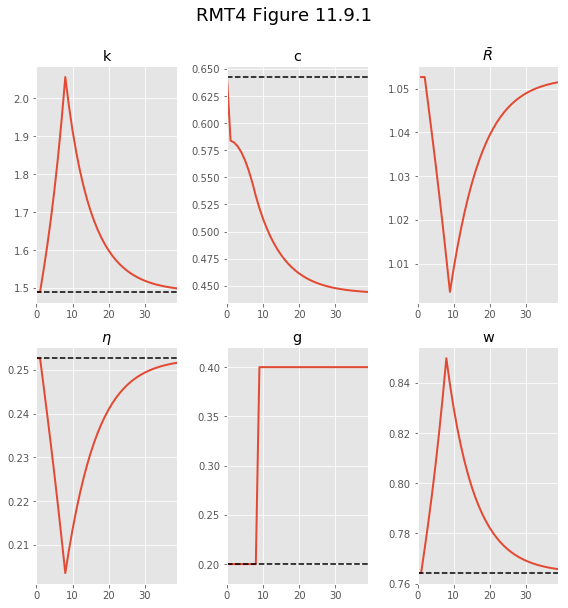

In [10]:
# Generate plots
psol = sol.iloc[:p_T]
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(8, 8))
for ind_i, i in enumerate(names):
    for ind_k, k in enumerate(i):
        ax_ik = axes[ind_i, ind_k]
        psol[k].plot(ax=ax_ik, linewidth=2, title=titles[ind_i][ind_k])
        ax_ik.plot(o * ss_vals[ind_i][ind_k], 'k--')
axes[1,1].set_ybound(.18, .42)
fig.suptitle('RMT4 Figure 11.9.1', fontsize=18, y=1.05)
fig.tight_layout()

Constructing that plot was a lot of book-keeping work.

Thankfully there is a convenient function in dolo that will do most of that work for us, while still allowing us to customize and tweak the figure to our liking. Here's another way we might have created the figure above.

In [11]:
# construct dictionary of plot keyword arguments. 
# We do this so we can re-use them below.
# line_options is applied to all lines in a particular DataFrame
plot_kwargs = dict(variables=['k','c','Rb','eta','g', 'w'],
                   line_options=[
                       {'color':'black', 'linestyle':'--'},
                       {'linewidth':2},
                       {'linewidth':2, "linestyle": "-."},
                   ],
                   titles=['k', 'c', r'$\bar{R}$', r'$\eta$', 'g', 'w'])

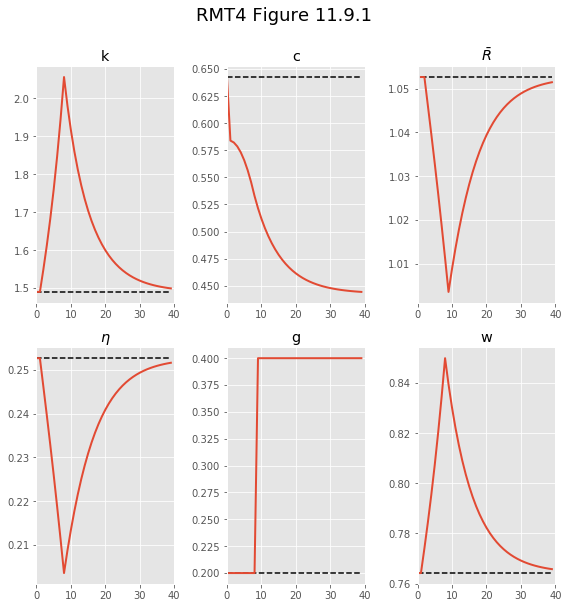

In [12]:
fig = plot_irfs([sol_ref, psol], **plot_kwargs)
fig.suptitle('RMT4 Figure 11.9.1', fontsize=18, y=1.05)
fig.tight_layout()

This was a much easier way to construct the same plot. We will use this approach going forward.

## Change in IES (RMT3 Figure 11.9.2)

We now want to highlight the impact of the parameter $\gamma$ in the household's preferences. The intertemporal elasticity of substitution (IES) for these preferences is given by $1/\gamma$. This means that higher values of $\gamma$ decrease IES, making the household less willing to substitute consumption across time.

Let's perform the same experiment as above, but this time with $\gamma$ set to $0.2$ instead of $2.0$.

In [13]:
# Change gamma and compute solution again
model.set_calibration(gamma=0.2)
sol_ies = pf.deterministic_solve(model, shocks=shocks_1, T=T, ignore_constraints=True)
sol_ies["Rb"] = model.eval_formula(Rbar_formula, dataframe=sol_ies)
psol_ies = sol_ies.iloc[:p_T]

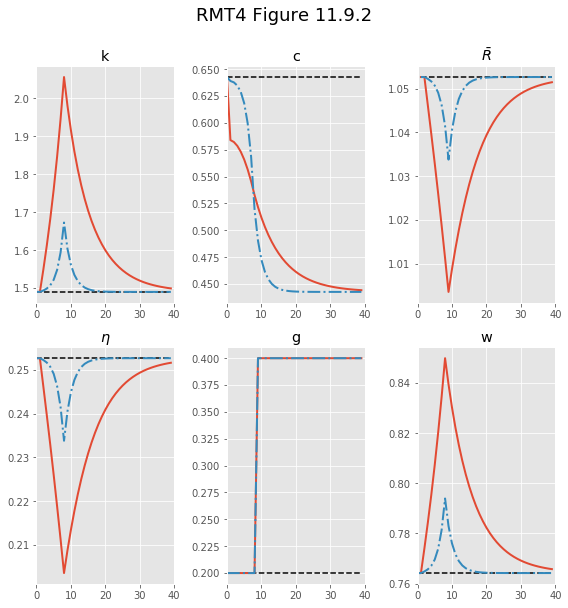

In [14]:
# generate figure
fig = plot_irfs([sol_ref, psol, psol_ies], **plot_kwargs)
fig.suptitle('RMT4 Figure 11.9.2', fontsize=18, y=1.05)
fig.tight_layout()

In the figure above the solid red line represents the experiment when $\gamma=2.0$, the dash-dotted blue line tracks the equilibrium in the experiment when $\gamma=0.2$, and the black dashed line tracks the steady state.

Notice that because the household is more willing to move consumption across time when $\gamma$ is smaller, the movement from initial to final levels of consumption is both larger and quicker. This lets the consumption stream "swallow" most of the impact of the increase in $g$ and capital doesn't respond as much (think about the household budget constraint). Factor prices and $\bar{R}$ are functions of the captial stock, so they also do not respond as sharply.

## Prices and interest rates (RMT3 Figure 11.9.3)

We will now return to the case where $\gamma=2.0$ and take a closer look at prices and interest rates in this economy.

We say that $R_{t,t+1}$ is the gross one period interest rate between $t$ and $t+1$. In equilibrium it can be written:

$$R_{t,t+1}= \left[(1 - \tau_{kt+1})(\alpha A k_{t+1}^{\alpha-1} - \delta) + 1 \right]$$.

We define $r_{t,t+1} := R_{t,t+1} - 1$ as the corresponding net interest rate.

Finally we define $r_{t,t+s}$ to be the net $s$ period interest rate between periods $t$ and $t+s$. It is defined as

$$r_{t,t+s} = \frac{1}{s} \left(r_{t,t+1} + r_{t+1,t+2} + \cdots + r_{t+s-1,t+s} \right) = - \frac{1}{s} \log \left(\frac{q_{t+s}}{q_t}\right).$$

A plot of $r_{t,t+s}$ as $s$ increases is called the real yield curve at $t$. Below we will plot the yield curve at $t=0,10,60$.

Let's construct each of those objects now.

In [15]:
# reset gamma
model.set_calibration(gamma=2.0)


# helper function to make it easier to add variables
def add_variable(name, formula, dfs=[sol, sol_ref]):
    for df in dfs:
        df[name] = model.eval_formula(formula, dataframe=df)

# this define new (constant) variables
sol["c0"] = sol["c"][0]
sol_ref["c0"] = sol_ref["c"][0]
# this is why they are referred to with time subscripts in the following formulas

add_variable("q", "beta**(t+1)*c(0)**(-gamma)/(c0(0)**(-gamma))")
add_variable("qbar", "beta**t")
add_variable("R", "(1-tau_k(1)) * (alpha*A*k(1)**(alpha-1) - delta) + 1")
add_variable("r", "R(0)-1")

In [16]:
# now construct yield curve at t=0, t=10, t=60
s = np.arange(p_T)
nans = np.ones(sol.shape[0]-p_T)*np.nan
q = np.array(sol["q"])
for t in [0, 10, 60]:
    rs = np.log(q[s+t]/q[t]) /(-s)
    # pad the array with NaN so we can add as a column to df
    sol["rs_{0}".format(t)] = np.concatenate([rs, nans])

Now we are ready to construct the plot we are after.

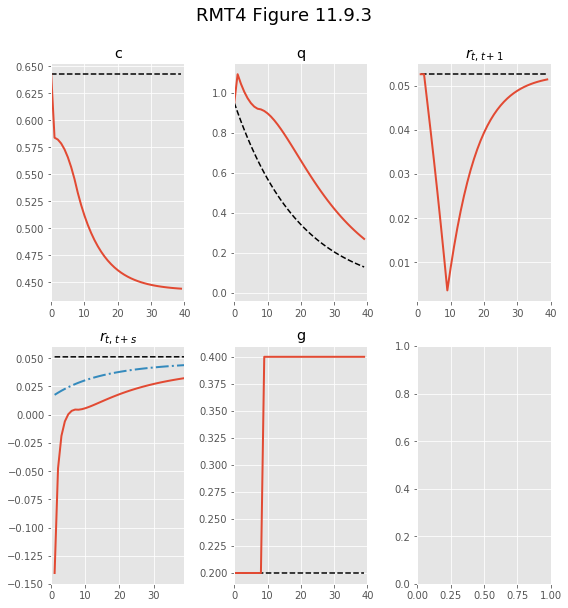

In [17]:
# note, this is a little hack to make it so we can use the
# handy `plot_irf` functions to get the yield curve at t=0 and t=60
sol_ref["rs_0"] = sol["rs_60"]

# now construct figure
fig = plot_irfs([sol_ref, sol], variables=["c", "q", "r", "rs_0", "g"],
                line_options=plot_kwargs["line_options"],
                titles=["c", "q", r"$r_{t,t+1}$", r"$r_{t,t+s}$", "g"]);

# add in the t=10 yeild curve and a title
sol["rs_10"][:p_T].plot(ax=fig.axes[3], **plot_kwargs["line_options"][2])
fig.suptitle('RMT4 Figure 11.9.3', fontsize=18, y=1.05);
fig.tight_layout()

## Consumption tax shocks (RMT 3 Figure 11.3.4)

Now let's consider the second experiment: a once-and-for-all increase in $\tau_c$ from 0 to 0.2 in period 10.

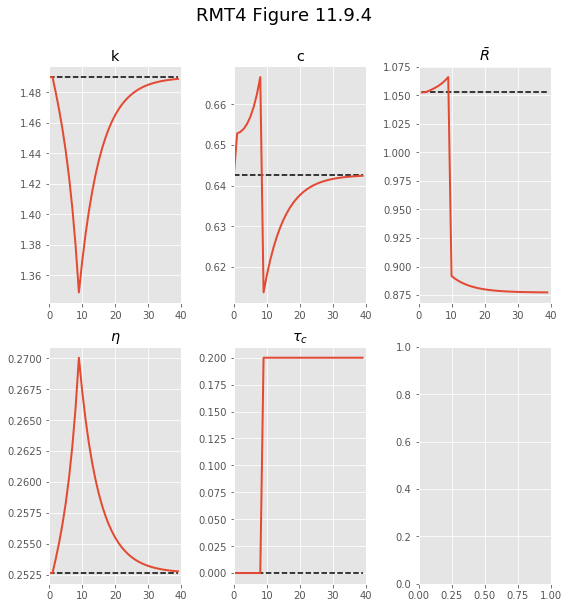

In [18]:
sol2 = pf.deterministic_solve(model, shocks=shocks_2, 
                               T=T, ignore_constraints=True)
sol2["Rb"] = model.eval_formula(Rbar_formula, dataframe=sol2)
psol2 = sol2.iloc[:p_T]

fig = plot_irfs([sol_ref, psol2], variables=["k", "c", "Rb", "eta", "tau_c"],
                titles=["k", "c", r"$\bar{R}$", r"$\eta$", r"$\tau_c$"],
                line_options=plot_kwargs["line_options"])
fig.suptitle('RMT4 Figure 11.9.4', fontsize=18, y=1.05);
fig.tight_layout()

## Capital tax shocks (RMT 3 Figure 11.9.5)

Next, we turn to the third experiment: a once-and-for-all increase in $\tau_k$ from 0 to 0.2 in period 10

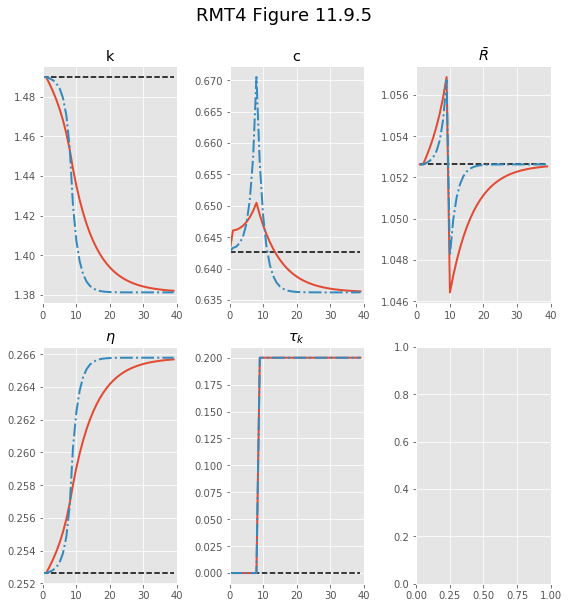

In [19]:
sol3 = pf.deterministic_solve(model, shocks=shocks_3, 
                               T=T, ignore_constraints=True)
sol3["Rb"] = model.eval_formula(Rbar_formula, dataframe=sol3)
psol3 = sol3.iloc[:p_T]

# here we also want to look at the impact of changing the ies
model.set_calibration(gamma=0.2)
sol3_ies = pf.deterministic_solve(model, shocks=shocks_3, 
                               T=T, ignore_constraints=True)
sol3_ies["Rb"] = model.eval_formula(Rbar_formula, dataframe=sol3_ies)
psol3_ies = sol3_ies.iloc[:p_T]
model.set_calibration(gamma=2.0)  # reset gamma

fig = plot_irfs([sol_ref, psol3, psol3_ies], variables=["k", "c", "Rb", "eta", "tau_k"],
                titles=["k", "c", r"$\bar{R}$", r"$\eta$", r"$\tau_k$"],
                line_options=plot_kwargs["line_options"])
fig.suptitle('RMT4 Figure 11.9.5', fontsize=18, y=1.05);
fig.tight_layout()

## Impulse shock to g (RMT 3 Figure 11.9.6)

Finally, we turn to the fourth experiment: a one-time shock to $g$ from 0.2 to 0.4 in period 10, then back to 0.2 forever.

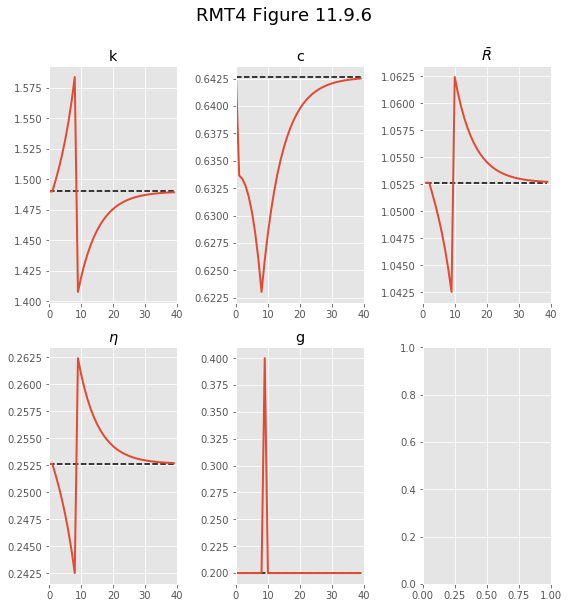

In [20]:
sol4 = pf.deterministic_solve(model, shocks=shocks_4, 
                               T=T, ignore_constraints=True)
sol4["Rb"] = model.eval_formula(Rbar_formula, dataframe=sol4)
psol4 = sol4.iloc[:p_T]

fig = plot_irfs([sol_ref, psol4], variables=["k", "c", "Rb", "eta", "g"],
                titles=["k", "c", r"$\bar{R}$", r"$\eta$", "g"],
                line_options=plot_kwargs["line_options"])
fig.suptitle('RMT4 Figure 11.9.6', fontsize=18, y=1.05)
fig.tight_layout()